## Assignment
### Over view :
Identify top countries that are direct need of aid. Your job is to categorise the countries using some
socio-economic and health factors that determine the overall development of the country. Then you
need to suggest the countries which the CEO needs to focus on the most.


# 1. Read and visualise the data

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the dataset
country_df = pd.read_csv("Country-data.csv")
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# basics of the df
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


# 2. Clean the data

### 2.1 Convert import , export and health in actual values

In [4]:
country_df['importquantity'] = country_df['imports']*country_df['gdpp']*0.01
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,importquantity
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,248.297
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1987.740
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1400.440
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1514.370
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,7185.800


In [5]:
country_df['exportquantity'] = country_df['exports']*country_df['gdpp']*0.01
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,importquantity,exportquantity
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,248.297,55.30
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1987.740,1145.20
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1400.440,1712.64
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1514.370,2199.19
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,7185.800,5551.00


In [6]:
country_df['heathquantity'] = country_df['health']*country_df['gdpp']*0.01
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,importquantity,exportquantity,heathquantity
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,248.297,55.30,41.9174
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1987.740,1145.20,267.8950
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1400.440,1712.64,185.9820
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1514.370,2199.19,100.6050
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,7185.800,5551.00,735.6600


In [7]:
# missing values
round(100*(country_df.isnull().sum())/len(country_df), 2)

country           0.0
child_mort        0.0
exports           0.0
health            0.0
imports           0.0
income            0.0
inflation         0.0
life_expec        0.0
total_fer         0.0
gdpp              0.0
importquantity    0.0
exportquantity    0.0
heathquantity     0.0
dtype: float64

C:\Users\ksimran\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


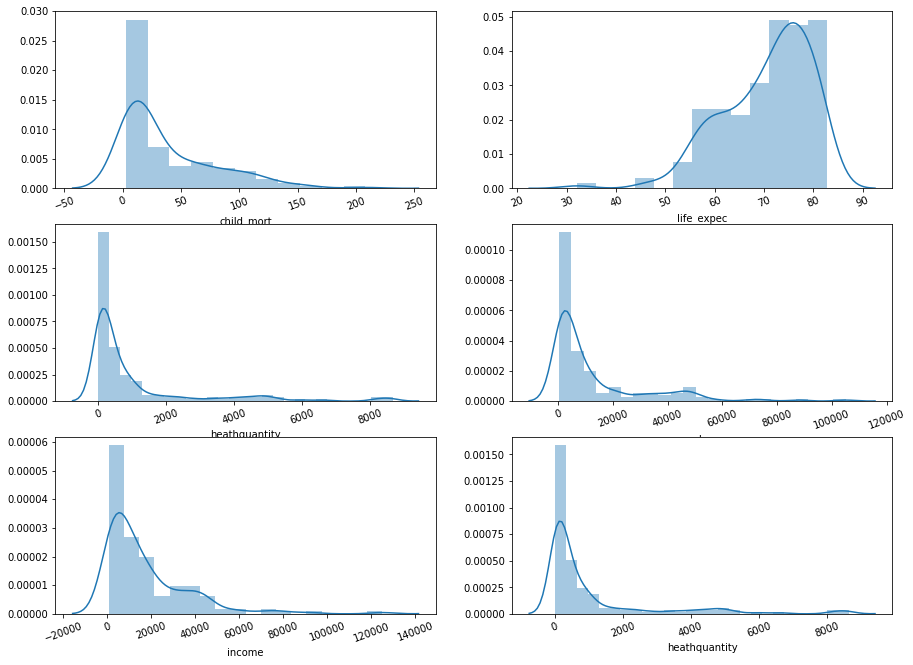

In [8]:
plt.figure(figsize=(15,15))
features = ['child_mort', 'life_expec', 'heathquantity', 'gdpp' ,'income' ,'heathquantity']
for i in enumerate(features): 
    ax = plt.subplot(4, 2, i[0]+1)
    sns.distplot(country_df[i[1]])
    plt.xticks(rotation = 20)

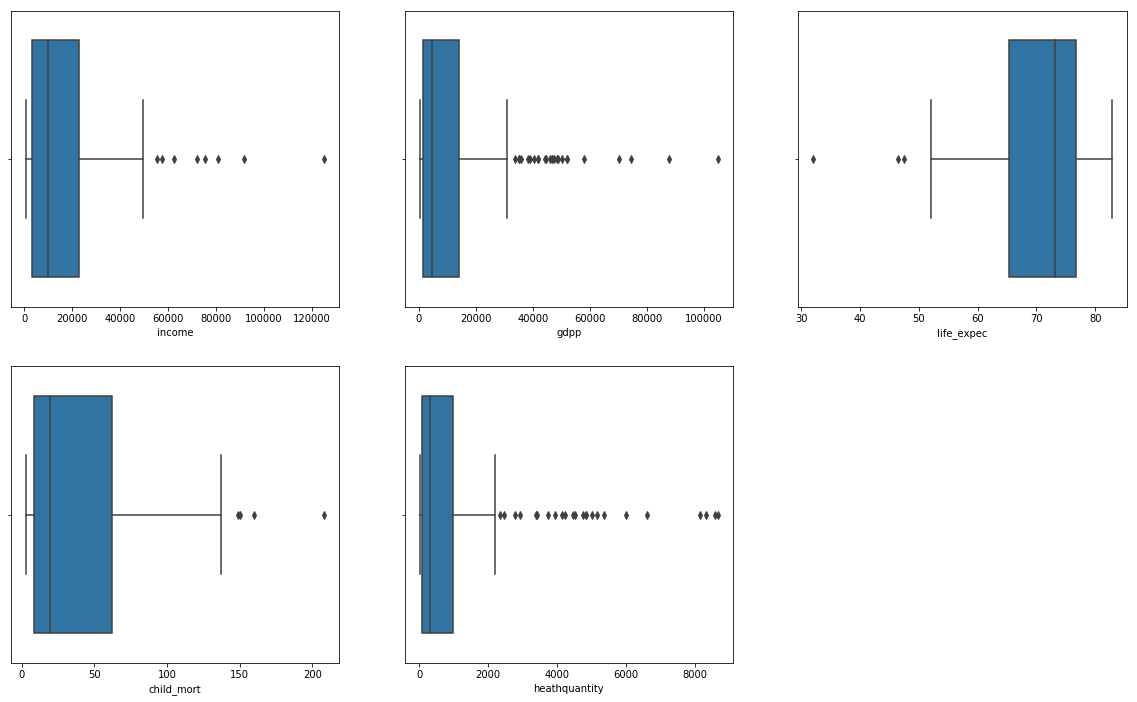

In [9]:
# 1. outlier treatment

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'income', data = country_df)
plt.subplot(2,3,2)
sns.boxplot(x = 'gdpp', data = country_df)
plt.subplot(2,3,3)
sns.boxplot(x = 'life_expec', data = country_df)
plt.subplot(2,3,4)
sns.boxplot(x = 'child_mort', data = country_df)
plt.subplot(2,3,5)
sns.boxplot(x = 'heathquantity', data = country_df)
plt.show()

In [10]:
country_df.describe() 

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,importquantity,exportquantity,heathquantity
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689,6588.352108,7420.618847,1056.733204
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809,14710.810418,17973.885795,1801.408906
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000,0.651092,1.076920,12.821200
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000,640.215000,447.140000,78.535500
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,2045.580000,1777.440000,321.886000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7719.600000,7278.000000,976.940000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,149100.000000,183750.000000,8663.600000


### Capping the outliers

In [11]:
features = ['child_mort','exports','health', 'imports','income', 'inflation','life_expec', 'total_fer', 'gdpp']
for i in enumerate(features): 
    print(country_df[i[1]])
    Q1 = country_df[i[1]].quantile(0.01)
    Q4 = country_df[i[1]].quantile(0.99)
    country_df[i[1]][country_df[i[1]] <= Q1]=Q1
    country_df[i[1]][country_df[i[1]] >= Q4]=Q4  
    

country_df.shape

0       90.2
1       16.6
2       27.3
3      119.0
4       10.3
5       14.5
6       18.1
7        4.8
8        4.3
9       39.2
10      13.8
11       8.6
12      49.4
13      14.2
14       5.5
15       4.5
16      18.8
17     111.0
18      42.7
19      46.6
20       6.9
21      52.5
22      19.8
23      10.5
24      10.8
25     116.0
26      93.6
27      44.4
28     108.0
29       5.6
       ...  
137     53.7
138      4.1
139      3.8
140     11.2
141     20.7
142     76.7
143     24.1
144      3.0
145      4.5
146     52.4
147     71.9
148     14.9
149     62.6
150     90.3
151     17.4
152     17.4
153     19.1
154     62.0
155     81.0
156     11.7
157      8.6
158      5.2
159      7.3
160     10.6
161     36.3
162     29.2
163     17.1
164     23.3
165     56.3
166     83.1
Name: child_mort, Length: 167, dtype: float64
0      10.00
1      28.00
2      38.40
3      62.30
4      45.50
5      18.90
6      20.80
7      19.80
8      51.30
9      54.30
10     35.00
11     69.50
12   

C:\Users\ksimran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ksimran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys



0      44.9
1      48.6
2      31.4
3      42.9
4      58.9
5      16.0
6      45.3
7      20.9
8      47.8
9      20.7
10     43.7
11     50.9
12     21.8
13     48.7
14     64.5
15     74.7
16     57.5
17     37.2
18     70.7
19     34.3
20     51.3
21     51.3
22     11.8
23     28.0
24     53.0
25     29.6
26     39.2
27     59.5
28     27.0
29     31.0
       ... 
137    27.4
138    46.2
139    26.8
140    26.8
141    57.1
142    17.2
143    38.4
144    40.7
145    53.3
146    58.6
147    29.1
148    60.8
149    27.8
150    57.3
151    60.3
152    55.3
153    25.5
154    44.5
155    28.6
156    51.1
157    63.6
158    30.8
159    15.8
160    25.4
161    28.5
162    52.7
163    17.6
164    80.2
165    34.4
166    30.9
Name: imports, Length: 167, dtype: float64
0       1610
1       9930
2      12900
3       5900
4      19100
5      18700
6       6700
7      41400
8      43200
9      16000
10     22900
11     41100
12      2440
13     15300
14     16200
15     41100
16      7880
17 

C:\Users\ksimran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\ksimran\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


(167, 13)

In [12]:
country_df.describe() 

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,importquantity,exportquantity,heathquantity
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,37.904790,40.818376,6.787614,46.760096,16858.601677,7.397332,70.645269,2.942896,12757.456527,6588.352108,7420.618847,1056.733204
std,39.026793,25.697471,2.642518,23.052216,17956.060832,7.770993,8.553975,1.497595,17429.755235,14710.810418,17973.885795,1801.408906
min,2.800000,3.909400,2.121800,12.988000,742.240000,-2.348800,47.160000,1.243200,331.620000,0.651092,1.076920,12.821200
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000,640.215000,447.140000,78.535500
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,2045.580000,1777.440000,321.886000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7719.600000,7278.000000,976.940000
max,153.400000,160.480000,13.474000,146.080000,84374.000000,41.478000,82.370000,6.563600,79088.000000,149100.000000,183750.000000,8663.600000


### Scaling the data

In [13]:
# 2. rescaling
rfm_df = country_df[['child_mort', 'income', 'gdpp']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(167, 3)

In [14]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['child_mort', 'income', 'gdpp']
rfm_df_scaled.head()

,child_mort,income,gdpp
0,1.344012,-0.851772,-0.702314
1,-0.547543,-0.387025,-0.498775
2,-0.272548,-0.221124,-0.477483
3,2.084186,-0.612136,-0.531000
4,-0.709457,0.125202,-0.032079


# 3. Modelling

### elbow

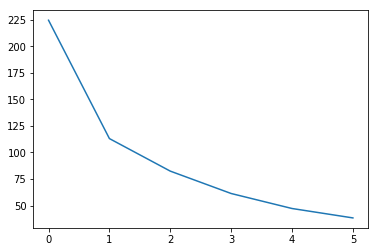

In [15]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5,6,7]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

Central African Republic	 value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [16]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.566490989486534
For n_clusters=3, the silhouette score is 0.5376288785294654
For n_clusters=4, the silhouette score is 0.5366883931729207
For n_clusters=5, the silhouette score is 0.47921652959750805
For n_clusters=6, the silhouette score is 0.4690035501773468
For n_clusters=7, the silhouette score is 0.45786318376131135
For n_clusters=8, the silhouette score is 0.4597026108244382


### Choosing k = 4 based on above analysis

In [17]:
# final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 3, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 1, 3, 2, 1, 2, 2, 1,
       1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       0, 0, 1, 1, 3, 0, 1, 2, 2, 2, 2, 2, 0, 3, 2, 2, 1, 2, 0, 1, 2, 2,
       1, 3, 2, 0, 2, 2, 0, 0, 2, 2, 1, 2, 0, 3, 2, 1, 2, 1, 1, 2, 2, 2,
       1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [19]:

country_df['cluster_id'] = kmeans.labels_
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,importquantity,exportquantity,heathquantity,cluster_id
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,248.297,55.30,41.9174,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,1987.740,1145.20,267.8950,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460.0,1400.440,1712.64,185.9820,2
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530.0,1514.370,2199.19,100.6050,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200.0,7185.800,5551.00,735.6600,2


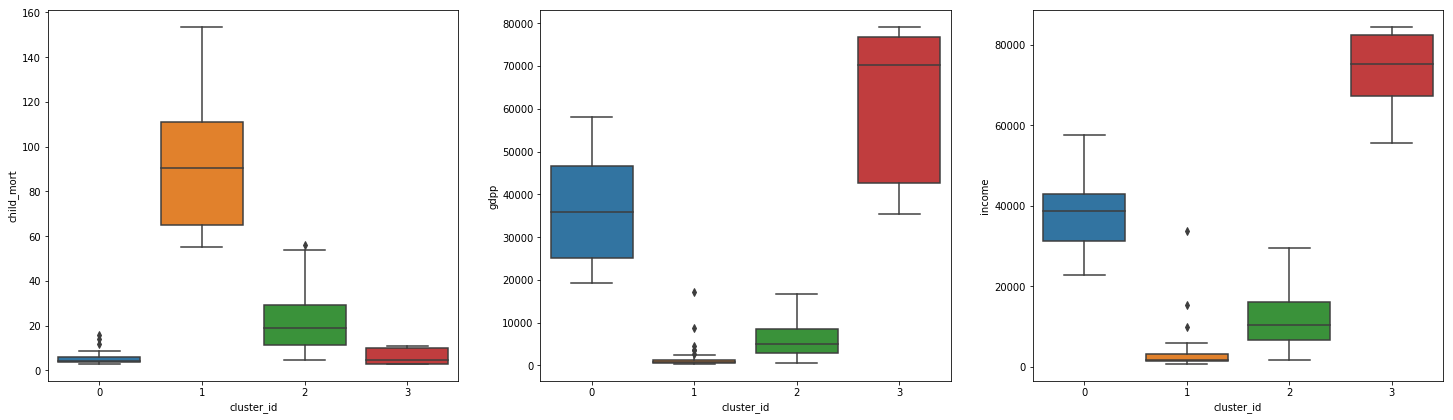

In [20]:

plt.figure(figsize=(25, 15))
# plot
plt.subplot(2,3,1)
sns.boxplot(x='cluster_id', y='child_mort', data=country_df)
# plot
plt.subplot(2,3,2)
sns.boxplot(x='cluster_id', y='gdpp', data=country_df)
plt.subplot(2,3,3)
# plot
sns.boxplot(x='cluster_id', y='income', data=country_df)

In [21]:
country_df['cluster_id'].value_counts()

2    83
1    46
0    31
3     7
Name: cluster_id, dtype: int64

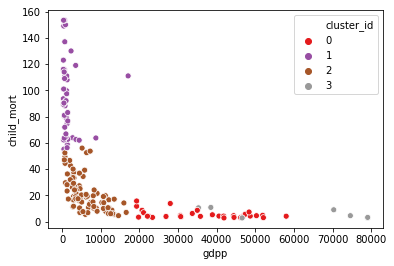

In [22]:
# Plot the Cluster with respect to the clusters obtained
sns.scatterplot(x = 'gdpp', y = 'child_mort', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

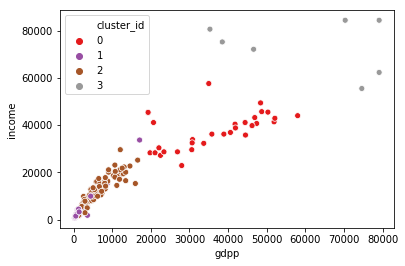

In [23]:
sns.scatterplot(x = 'gdpp', y = 'income', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

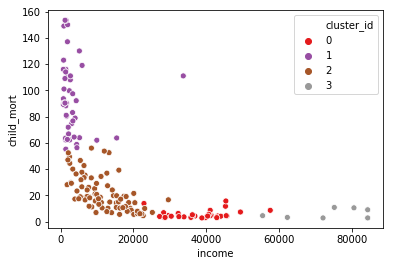

In [24]:
sns.scatterplot(x = 'income', y = 'child_mort', hue ='cluster_id', legend = 'full', data = country_df, palette='Set1')

## Cluster Profiling

In [25]:
country_df.drop(['life_expec','total_fer','exports' ,'country' ,'health' ,'imports' ,'importquantity' ,'inflation' ,'exportquantity','heathquantity'], axis = 1).groupby('cluster_id').mean()

,child_mort,income,gdpp
cluster_id,,,
0,5.509677,37748.387097,36183.870968
1,93.350000,3414.749565,1606.853043
2,21.946988,11730.843373,6161.493976
3,6.228571,73492.571429,60496.571429


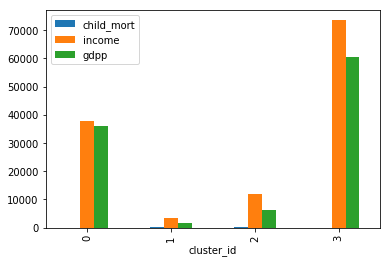

In [26]:
country_df.drop(['life_expec','total_fer','exports' ,'country' ,'health' ,'imports' ,'importquantity' ,'inflation' ,'exportquantity','heathquantity'], axis = 1).groupby('cluster_id').mean().plot(kind='bar')

## Clearly after Cluster Profiling we can see that Cluster 1 contries are the one that needs max help with high child mortality , low income and low gdpp

### Finding the observations that belong to  cluster 1

In [27]:
#Let's use the concept of binning
country_df[country_df['cluster_id']==1]['country']

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
69                        India
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106                  Mozambique
107     

### Now we need to find top 5 countries

In [28]:
#sorting the data to get top 3 list
country_df.head()
country_df.drop(['life_expec','total_fer','exports'  ,'health' ,'imports' ,'importquantity' ,'inflation' ,'exportquantity','heathquantity'], axis=1 ,inplace = True)


In [47]:
country_df[country_df['cluster_id']==1].sort_values(by=["child_mort", 'income' , 'gdpp'], ascending=[False ,True, True]).head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
132,Sierra Leone,153.4,1220.0,399.0,1,0
66,Haiti,153.4,1500.0,662.0,1,0
32,Chad,150.0,1930.0,897.0,1,0
31,Central African Republic,149.0,888.0,446.0,1,0
97,Mali,137.0,1870.0,708.0,1,0


In [30]:
country_df[country_df['cluster_id']==1].sort_values(by=[ 'income' , 'gdpp' ,'child_mort'], ascending=[True, True ,False]).head()

,country,child_mort,income,gdpp,cluster_id
88,Liberia,89.3,742.24,331.62,1
37,"Congo, Dem. Rep.",116.0,742.24,334.00,1
26,Burundi,93.6,764.00,331.62,1
112,Niger,123.0,814.00,348.00,1
31,Central African Republic,149.0,888.00,446.00,1


In [31]:
country_df[country_df['cluster_id']==1].sort_values(by=[ 'gdpp' ,'child_mort','income' ], ascending=[ True,False, True]).head()

,country,child_mort,income,gdpp,cluster_id
26,Burundi,93.6,764.00,331.62,1
88,Liberia,89.3,742.24,331.62,1
37,"Congo, Dem. Rep.",116.0,742.24,334.00,1
112,Niger,123.0,814.00,348.00,1
132,Sierra Leone,153.4,1220.00,399.00,1


## Hierarchical Clustering

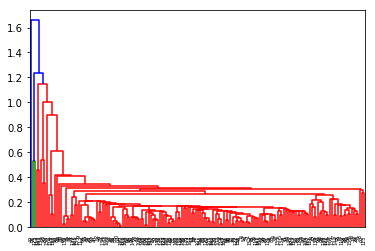

In [32]:
rfm_df_scaled.head()
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

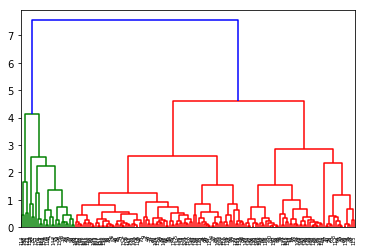

In [33]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [34]:
# 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0,
       1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       2, 1, 0, 0, 3, 2, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [35]:
# assign cluster labels
country_df['cluster_labels'] = cluster_labels
country_df.head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,1610.0,553.0,1,0
1,Albania,16.6,9930.0,4090.0,2,1
2,Algeria,27.3,12900.0,4460.0,2,1
3,Angola,119.0,5900.0,3530.0,1,0
4,Antigua and Barbuda,10.3,19100.0,12200.0,2,1


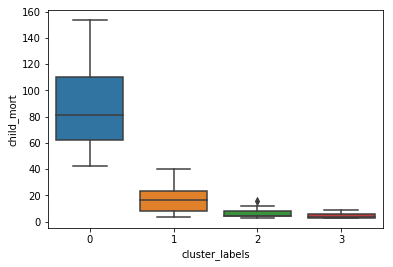

In [37]:
# plots
sns.boxplot(x='cluster_labels', y='child_mort', data=country_df)

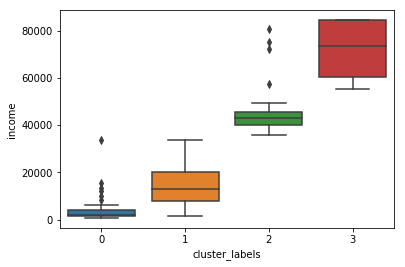

In [38]:
# plots
sns.boxplot(x='cluster_labels', y='income', data=country_df)

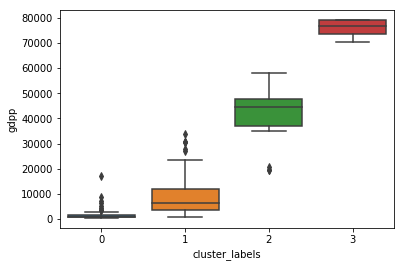

In [39]:
# plots
sns.boxplot(x='cluster_labels', y='gdpp', data=country_df)

### Seeing all these plots its clear to choose cluster 0 as it has high child mortality , low gdpp and income which is same what we got with k means

In [41]:
country_df[country_df['cluster_labels']==0].sort_values(by=["child_mort", 'income' , 'gdpp'], ascending=[False ,True, True]).head() 

,country,child_mort,income,gdpp,cluster_id,cluster_labels
132,Sierra Leone,153.4,1220.0,399.0,1,0
66,Haiti,153.4,1500.0,662.0,1,0
32,Chad,150.0,1930.0,897.0,1,0
31,Central African Republic,149.0,888.0,446.0,1,0
97,Mali,137.0,1870.0,708.0,1,0


In [40]:
country_df[country_df['cluster_labels']==0].sort_values(by=[ 'income' , 'gdpp' ,'child_mort'], ascending=[True, True ,False]).head()

,country,child_mort,income,gdpp,cluster_id,cluster_labels
88,Liberia,89.3,742.24,331.62,1,0
37,"Congo, Dem. Rep.",116.0,742.24,334.00,1,0
26,Burundi,93.6,764.00,331.62,1,0
112,Niger,123.0,814.00,348.00,1,0
31,Central African Republic,149.0,888.00,446.00,1,0


### we are getting the same result as k means

# Result
## Accoring to analysis below are the countries the needs aid
* Central African Republic
* Sierra Leone
* Niger
* Congo, Dem. Rep
* Liberia

